# <center>Explorary Data Analysis</center>

This notebook provides a time series analysis extracted from an intelligent buoys network stationed along the Irish coastline available <a href="https://erddap.marine.ie/erddap/tabledap/IWaveBNetwork.html">here</a>. A smart buoy is a sensor-equipped buoy to collect marine and aquatic data. These buoys' measurements encompass various indicators linked to oceanic conditions, encompassing parameters such as sea temperature, wave height, and sea water velocity.


# Contents:
* Import libraries 
* Load Dataset
* Type Downcasting /Reduce Memory Usage
* Feature Understanding
* Distribution
* Smoothing
* Correlations

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

color_pal = sns.color_palette()
sns.set_style('whitegrid')

pd.set_option('display.max_columns', None)

# Load Dataset
* The first row of dataset presents the columns measurement units, so we skip this row. 
* The time column is string, so we parse/convert it to datetime64 data type as we load the dataset.

In [ ]:
df = pd.read_csv('../input/wavebnetwork/WaveBNetwork.csv',
                 skiprows=[1],
                 parse_dates=['time'])

In [ ]:
# change column names to a shorter name for coding convenience
df = df.rename(columns={'SignificantWaveHeight':'SWH',
                        'SeaTemperature':'SeaTemp',
                        'MeanCurDirTo':'MeanCurDir',
                        'MeanCurSpeed':'MeanCurSpd'})

In [ ]:
# Set the datetime column as index
df = df.set_index('time')
df.index = pd.to_datetime(df.index)

In [ ]:
df.head(3)

,longitude,latitude,station_id,instrument,PeakPeriod,PeakDirection,UpcrossPeriod,SWH,SeaTemp,Hmax,THmax,MeanCurDir,MeanCurSpd
time,,,,,,,,,,,,,
2020-01-01 00:00:00+00:00,-10.149796,54.228027,AMETS Berth B Wave Buoy,Datawell WaveRider MkIII,10.53,291.60000,5.532,139.4,NaN,229.0,9.85,NaN,NaN
2020-01-01 00:00:00+00:00,-9.268117,53.228966,SmartBay Wave Buoy,Datawell WaveRider 4,9.09,242.81319,3.100,42.0,8.24,81.0,8.93,318.94507,0.216
2020-01-01 00:03:00+00:00,-10.149796,54.228027,AMETS Berth B Wave Buoy,Datawell WaveRider MkIII,10.53,293.90000,5.510,136.2,NaN,NaN,NaN,NaN,NaN


# Type Downcasting /Reduce Memory Usage

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1845100 entries, 2020-01-01 00:00:00+00:00 to 2023-07-05 21:25:00+00:00
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   longitude      float64
 1   latitude       float64
 2   station_id     object 
 3   instrument     object 
 4   PeakPeriod     float64
 5   PeakDirection  float64
 6   UpcrossPeriod  float64
 7   SWH            float64
 8   SeaTemp        float64
 9   Hmax           float64
 10  THmax          float64
 11  MeanCurDir     float64
 12  MeanCurSpd     float64
dtypes: float64(11), object(2)
memory usage: 197.1+ MB


* In memory, dataset is taking 197.1 MB of RAM
* There are two object variables that could be categories
* Floats could change to smaller size based on their value range

In [ ]:
# find unique values for objest variables to test if they are true strings or just categories

print(f"There are {len(df['station_id'].unique())} unique station_ids:")
[print('\t', x) for x in df['station_id'].unique()]
print(f"\nThere are {len(df['instrument'].unique())} instruments:")
[print('\t', x) for x in df['instrument'].unique()]

There are 7 unique station_ids:
	 AMETS Berth B Wave Buoy
	 SmartBay Wave Buoy
	 AMETS Berth A Wave Buoy
	 Brandon Bay
	 Bantry Bay
	 Clew Bay
	 Finnis Waver

There are 2 instruments:
	 Datawell WaveRider MkIII
	 Datawell WaveRider 4


[None, None]

In [ ]:
df.describe().loc[['min','max']]

,longitude,latitude,PeakPeriod,PeakDirection,UpcrossPeriod,SWH,SeaTemp,Hmax,THmax,MeanCurDir,MeanCurSpd
min,-10.296102,51.647000,1.19,0.0,1.36,0.0,0.89,0.0,0.00,0.00000,0.000
max,-9.268117,54.279575,28.57,360.0,21.97,1873.3,27.61,4094.0,172.79,359.91208,2.425


* station_id and instrument can change to category type
* small float can change to float 32

In [ ]:
def set_dtypes(df):
    
    df['station_id'] = df['station_id'].astype('category')
    df['instrument'] = df['instrument'].astype('category')
    
    df['PeakPeriod'] = df['PeakPeriod'].astype('float32')
    df['UpcrossPeriod'] = df['UpcrossPeriod'].astype('float32')
    df['SeaTemp'] = df['SeaTemp'].astype('float32')
    df['Hmax'] = df['Hmax'].astype('float32') # if select float16 it will intrupts ffill cleanup process
    df['THmax'] = df['THmax'].astype('float32')
    df['MeanCurSpd'] = df['MeanCurSpd'].astype('float32')
    
    return df

df = set_dtypes(df)

* Reduced memory size from <b>197.1</b> MB to <b>130.2</b> MB.

# Feature Understanding
### 1- latitude, longitude, instrument, and station_id

In [ ]:
# Check if latitude and longitude are unique per station
# by counting distinct values in aggregation 

print('Number of Unique Values per station:')
df.groupby('station_id').agg({'latitude': pd.Series.nunique, 
                              'longitude': pd.Series.nunique,
                              'instrument': pd.Series.nunique}).reset_index()

Number of Unique Values per station:


,station_id,latitude,longitude,instrument
0,AMETS Berth A Wave Buoy,1,1,1
1,AMETS Berth B Wave Buoy,1,1,1
2,Bantry Bay,1,1,1
3,Brandon Bay,1,1,1
4,Clew Bay,1,1,1
5,Finnis Waver,1,1,1
6,SmartBay Wave Buoy,1,1,1


In [ ]:
# Find latitude and longitude of each station
locations = df.groupby(['station_id','instrument','latitude'])['longitude'].max().dropna().reset_index()
locations

,station_id,instrument,latitude,longitude
0,AMETS Berth A Wave Buoy,Datawell WaveRider MkIII,54.279575,-10.296102
1,AMETS Berth B Wave Buoy,Datawell WaveRider MkIII,54.228027,-10.149796
2,Bantry Bay,Datawell WaveRider 4,51.647000,-9.681000
3,Brandon Bay,Datawell WaveRider 4,52.282250,-10.094933
4,Clew Bay,Datawell WaveRider MkIII,53.801353,-9.911498
5,Finnis Waver,Datawell WaveRider 4,53.049400,-9.486017
6,SmartBay Wave Buoy,Datawell WaveRider 4,53.228966,-9.268117


* There are 7 stations located in 7 different geographical locations.
* Each station uses only one type of the two instruments.
* 4 stations use <b>Datawell WaveRider 4</b> instrument and 3 stations use <b>Datawell WaveRider MkIII</b> instrument. 

In [ ]:
# find number of samples grouped by station and its instrument
counts = df.groupby(['station_id','instrument']).size().reset_index()
counts.columns = ['station_id','instrument', 'size']
counts = counts.loc[counts['size']!=0]\
      .reset_index(drop=True)
counts

,station_id,instrument,size
0,AMETS Berth A Wave Buoy,Datawell WaveRider MkIII,481482
1,AMETS Berth B Wave Buoy,Datawell WaveRider MkIII,495319
2,Bantry Bay,Datawell WaveRider 4,167824
3,Brandon Bay,Datawell WaveRider 4,166179
4,Clew Bay,Datawell WaveRider MkIII,168645
5,Finnis Waver,Datawell WaveRider 4,36824
6,SmartBay Wave Buoy,Datawell WaveRider 4,328827


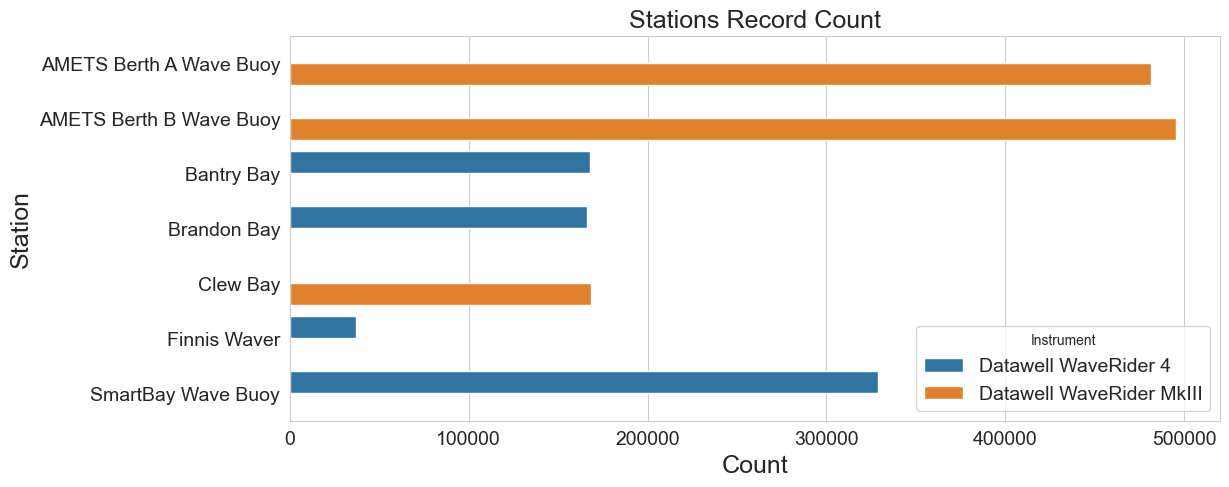

In [ ]:
#plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.barplot(counts, x='size', y='station_id', hue='instrument')
ax.set_xlabel('Count', fontsize=18)
ax.set_ylabel('Station', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.legend(title ='Instrument',fontsize=14)
ax.set_title('Stations Record Count', fontsize=18)
plt.show()

We'll plot the locations using X axis as longitude and Y axis as latitue to see stations' locations with respect to each other.

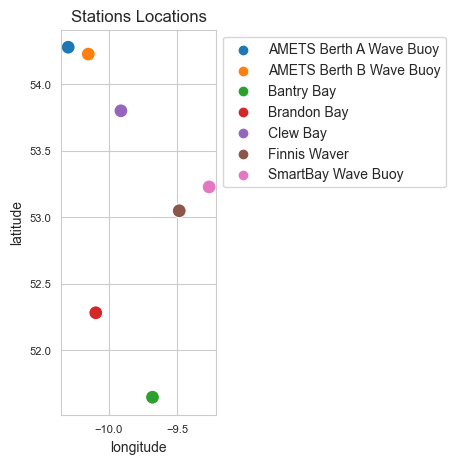

In [ ]:
#sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(2,5))
ax = sns.scatterplot(locations, x= 'longitude', y='latitude', hue='station_id', s=100)
ax.set_xlabel('longitude', fontsize=10);
ax.set_ylabel('latitude', fontsize=10);
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
ax.legend(title ='Instrument',fontsize=6)
ax.legend(bbox_to_anchor=(1, 1), loc=2)
ax.set_title('Stations Locations', fontsize=12)
plt.show()

Is each instrument specialized to record specific features in the dataset?

In [ ]:
# Find number of records for each feature grouped by instrument type
variables = df.columns.drop(['instrument'])
df.groupby('instrument')[variables].count().reset_index()

,instrument,longitude,latitude,station_id,PeakPeriod,PeakDirection,UpcrossPeriod,SWH,SeaTemp,Hmax,THmax,MeanCurDir,MeanCurSpd
0,Datawell WaveRider 4,699654,699654,699654,116879,116879,116879,116879,697985,115276,115276,349614,349640
1,Datawell WaveRider MkIII,1145446,1145446,1145446,1129727,1129727,1129727,1129727,0,121302,121302,0,0


* <b>SeaTemp</b>, <b>MeanCurDir</b>, and <b>MeanCurSpd</b> features are recorded only by instrument <b>Datawell WaveRider 4</b>. 
* Stations which are using the <b>Datawell WaveRider MkIII</b> instrument do not have any record of the above 3 features.

### 2- Target Variable (SWH)
Plot the target variable SWH per station.

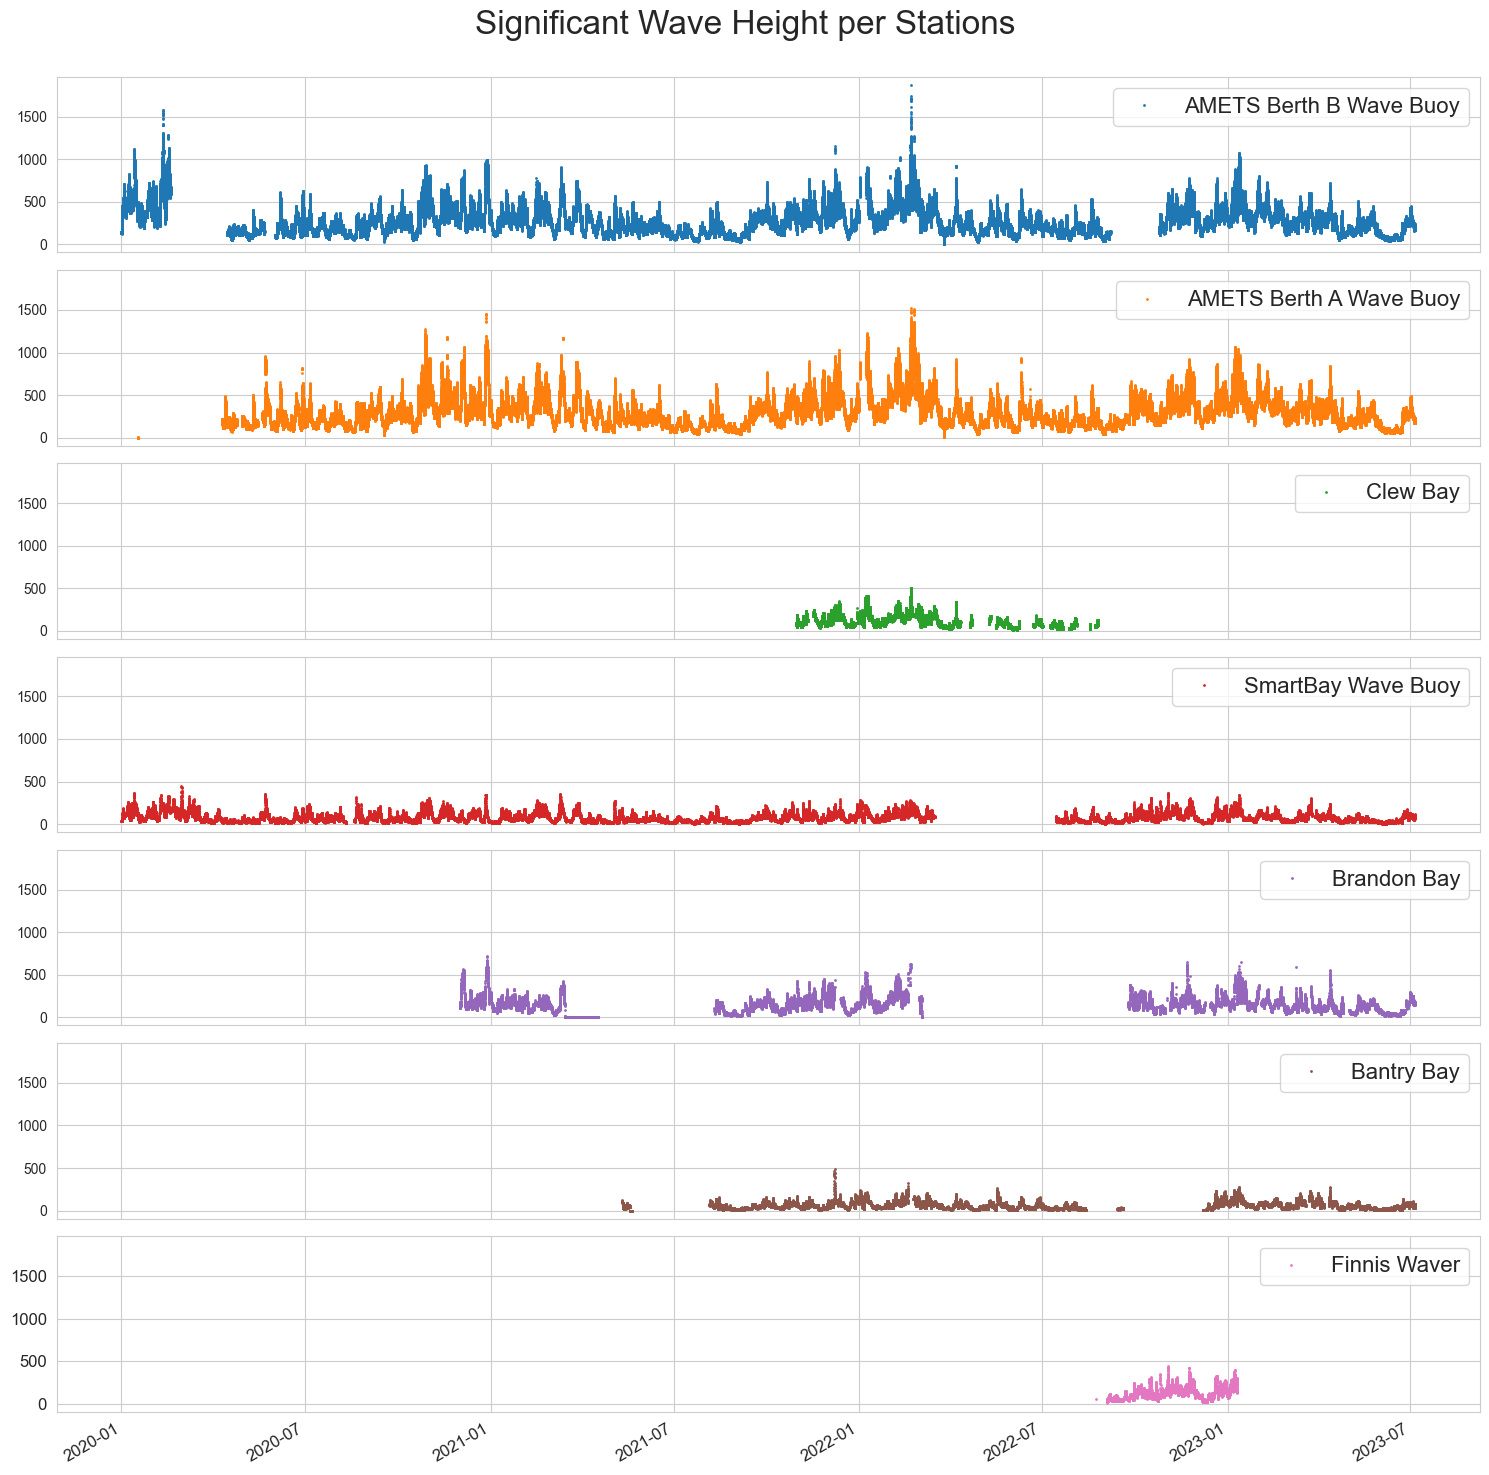

In [ ]:
#used instrument in the loop to plot stations based on the instrument orderd. 
instruments = ['Datawell WaveRider MkIII', 'Datawell WaveRider 4']

fig, axs = plt.subplots(7,1, figsize=(15,15), sharex = True, sharey=True)

n=0

# using two for loops to sort plots by instrument
for inst in instruments:
    stations = df[df['instrument']==inst]['station_id'].unique()
    for station in stations:
        base = df[df['station_id']==station]['SWH']
        base.plot(ax=axs[n],
                  color=color_pal[n],
                  style='.',
                  markersize=2,
                  label=station)
        axs[n].legend(fontsize=16)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        axs[n].set_xlabel(None)
        n+=1
fig.suptitle('Significant Wave Height per Stations\n', fontsize=24)
fig.tight_layout()
plt.show()
    

* The first two stations have the highest SWH.
* The first two stations and the forth station have the longest and the most consistant time series.

In [ ]:
# Find number of SWH records per station sorted
df.groupby('station_id')['SWH'].count().reset_index().sort_values('SWH', ascending=False)

,station_id,SWH
1,AMETS Berth B Wave Buoy,490836
0,AMETS Berth A Wave Buoy,470528
4,Clew Bay,168363
6,SmartBay Wave Buoy,55062
2,Bantry Bay,27939
3,Brandon Bay,27695
5,Finnis Waver,6183


####  One Month Data
Plot one month of SWH and Hmax data for the "AMETS Berth B Wave Buoy" station.

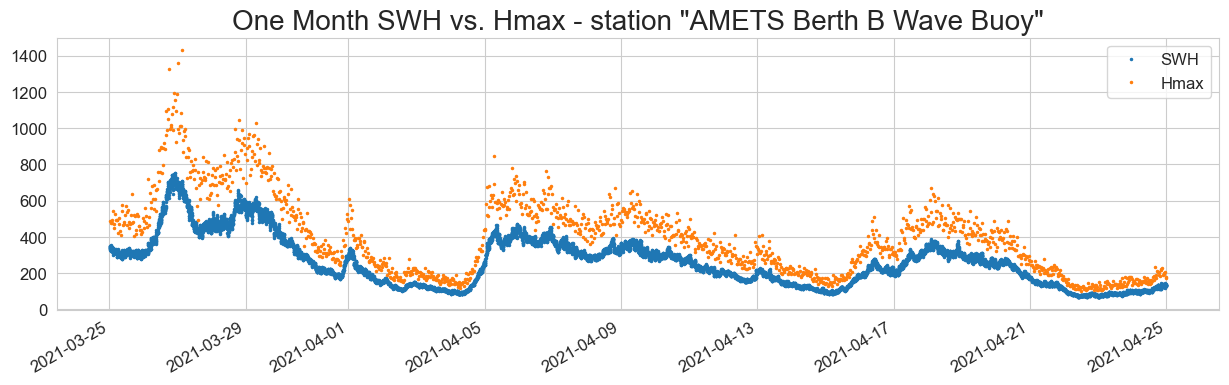

In [ ]:
station = 'AMETS Berth B Wave Buoy'
base = df[df['station_id']==station]
base = base[(base.index > '03-25-2021') & (base.index <= '04-25-2021')]
ax = base[['SWH','Hmax']].plot(figsize=(15,4),
                               style='.',
                               markersize=3)
plt.legend(fontsize=12)
ax.set_title(f'One Month SWH vs. Hmax - station "{station}"',fontsize=20)
ax.set_xlabel(None)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### 3- Hmax

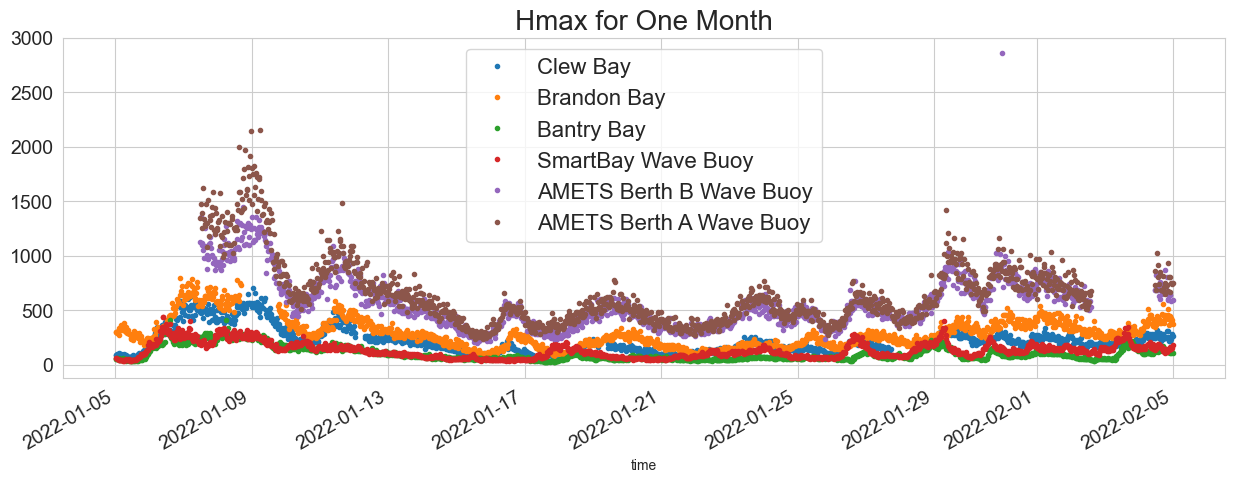

In [ ]:
base = df[(df.index > '2022-01-05') & (df.index < '2022-02-05')]
stations = base['station_id'].unique()
legend=[]
for station in stations:
    base[base['station_id'] == station]['Hmax'].plot(figsize=(15,5), style='.')
    legend.append(station)
plt.legend(legend, fontsize=16)
plt.title('Hmax for One Month', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

When we compare the maximum wave heights (Hmax) across all stations, it becomes evident that the stations "AMETS Berth A Wave Buoy" and "AMETS Berth B Wave Buoy" exhibit notably higher Hmax values similar to SWH.

# Distribution

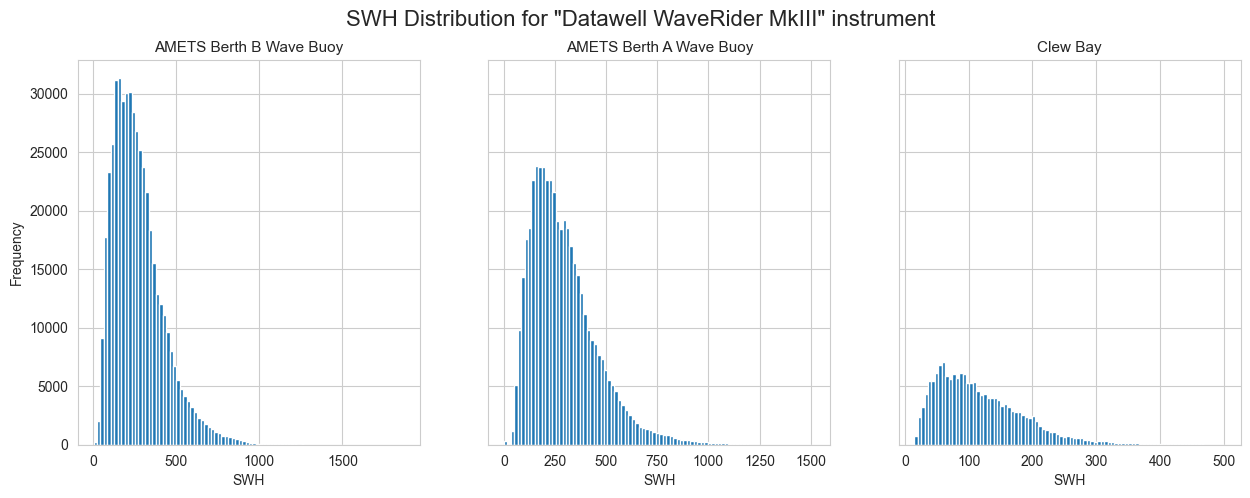

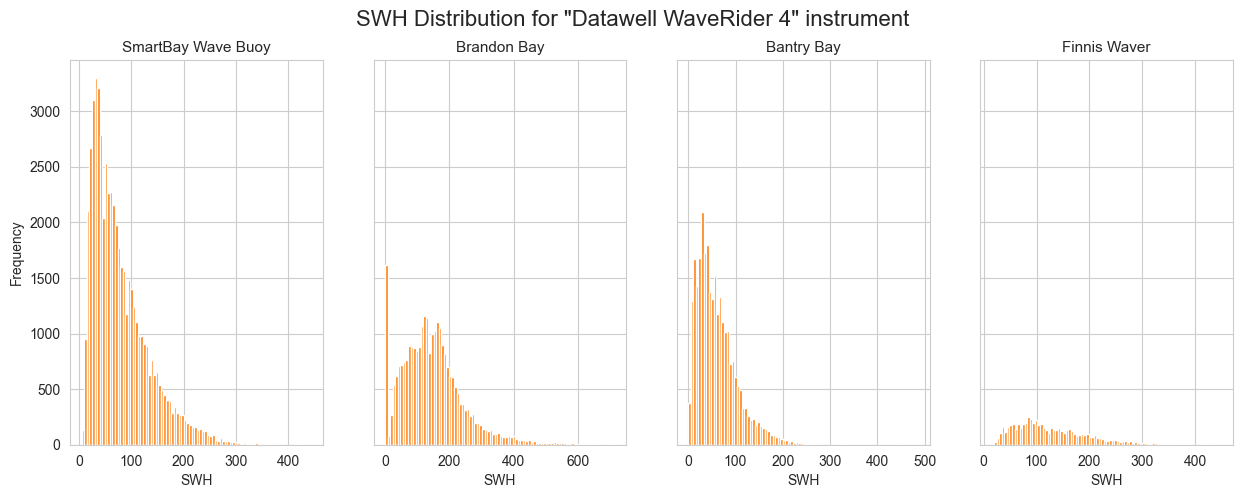

In [ ]:
sns.set_style('whitegrid')

instruments = df['instrument'].unique()
c=0
for instrument in instruments:
    stations = df[df['instrument']==instrument]['station_id'].unique()
    fig, axs = plt.subplots(1,len(stations), figsize=(15,5), sharey=True)
    for n,station in enumerate(stations):
        df.loc[df['station_id'] == station]['SWH'].plot(ax=axs[n], 
                                                        kind='hist', 
                                                        bins=90,
                                                        color=color_pal[c])
        axs[n].set_xlabel('SWH')
        axs[n].set_title(station,size=11)
    fig.suptitle(f'SWH Distribution for "{instrument}" instrument',fontsize=16)
    plt.show()
    c+=1

* SWH distributions are right skewed. This means there is a limit on the minimum possible SWH value (which is 0) but no limit on the maximum possible value (the waves could go high with no limit). The mean would be bigger than median, so the mean would overestimate the most common values.
* The difference in plots frequencies (Y axis) is due to different number of records in each station which is also visible in time series plots.

# Smoothing

In [ ]:
import matplotlib.dates as mdates
def monthly_moothing_plot(df, station, color):
    
    df = df.loc[df['station_id']==station].copy()
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['year_month'] = df[['year','month']].apply(lambda x: '-'.join(x.values.astype(str)), axis='columns')
    df['year_month'] = pd.to_datetime(df['year_month'])
    df= df[['SWH','year','month','year_month']]
    
    df_grouped = df.groupby('year_month')['SWH'].median()
    
    #fig, axs = plt.subplots(2,1, figsize=(15,8))
    
    ax = df_grouped.plot(figsize=(15,4), style='-', color=color)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.set_title(f'Monthly Smoothing - "{station}"', fontsize=18)
    ax.set_xlabel(None)
    ax.set_ylabel('SWH')
    plt.xticks(rotation = 90)
    plt.show()
    
    ax = df['SWH'].pct_change().plot(figsize=(15,4), color='black')
    ax.set_title(f'Monthly Percentage Change - "{station}"', fontsize=18)
    ax.set_xlabel(None)
    ax.set_ylabel('SWH')
    plt.xticks(rotation = 90)
    plt.show()

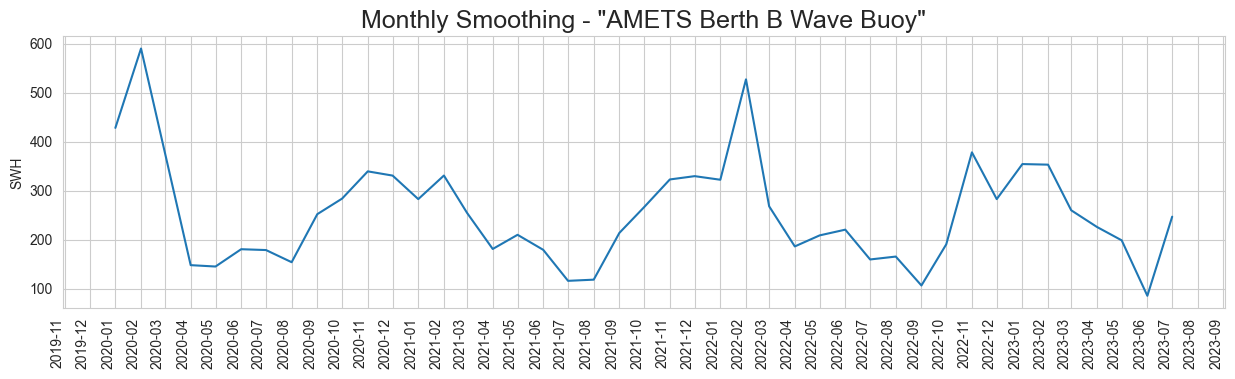

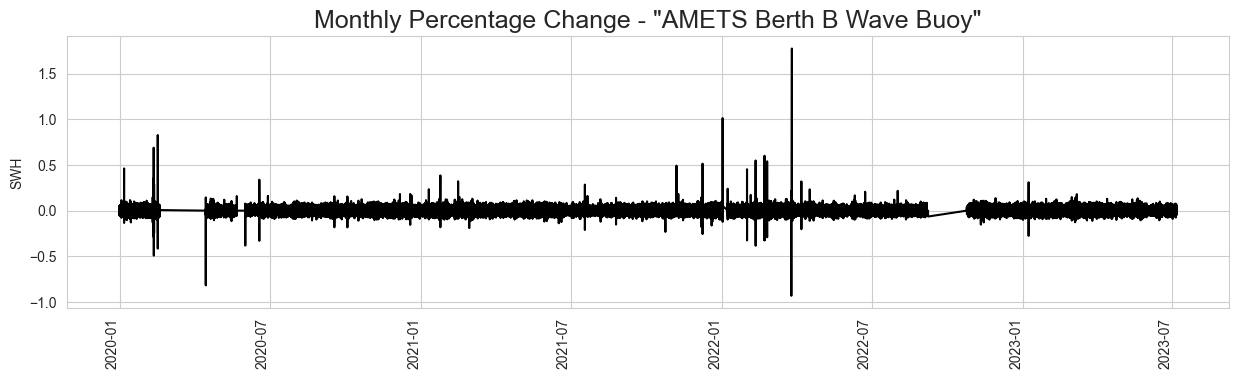

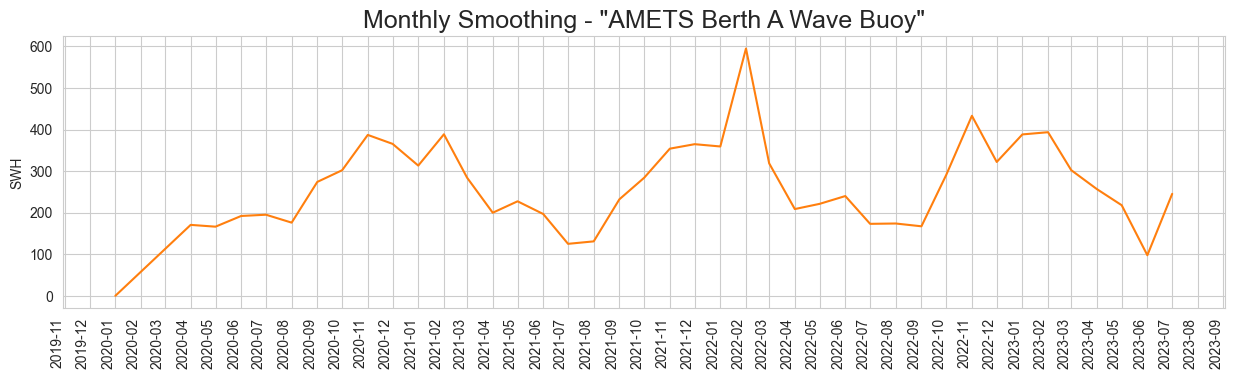

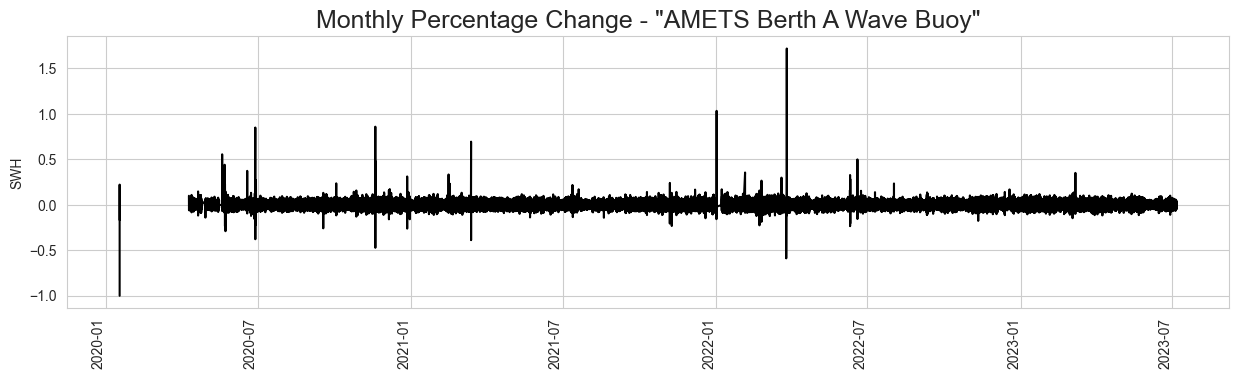

In [ ]:
monthly_moothing_plot(df, 'AMETS Berth B Wave Buoy',color_pal[0])  
monthly_moothing_plot(df, 'AMETS Berth A Wave Buoy', color_pal[1])   

In [ ]:
def monthly_smoothing_per_year_plot(df,station, show_piv=False):
    
    df = df.loc[df['station_id']==station].copy()
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['year_month'] = df[['year','month']].apply(lambda x: '-'.join(x.values.astype(str)), axis='columns')
    df['year_month'] = pd.to_datetime(df['year_month'])
    df = df[df['station_id']==station]
    df= df[['SWH','year','month','year_month']]
    
    piv = pd.pivot_table(df, index=['month'],columns=['year'], values=['SWH'], aggfunc='median')
    fig, ax = plt.subplots(figsize=(13,3))
    
    piv.plot(ax=ax)
    ax.legend(title ='Year',fontsize=10)
    ax.set_title(f'Monthly Resampled SWH Plot - {station}', fontsize=18)
    
    plt.show()
    
    if show_piv==True:
        display('Plot Data:', piv)
 

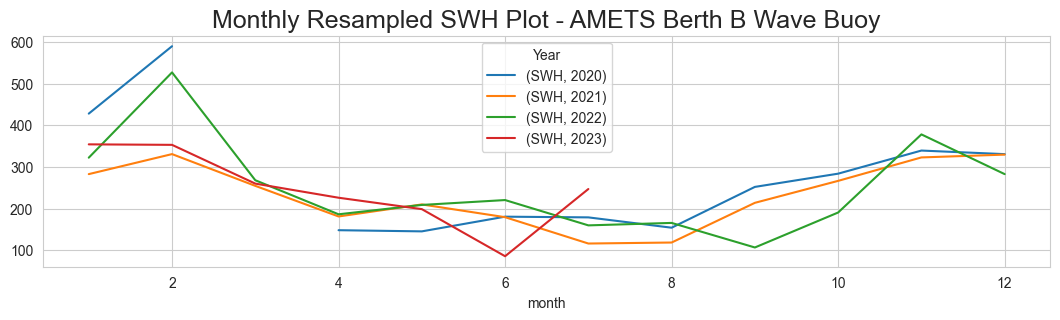

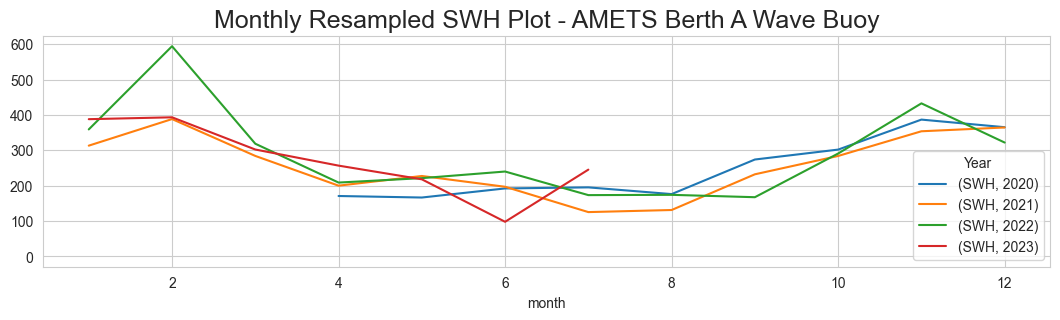

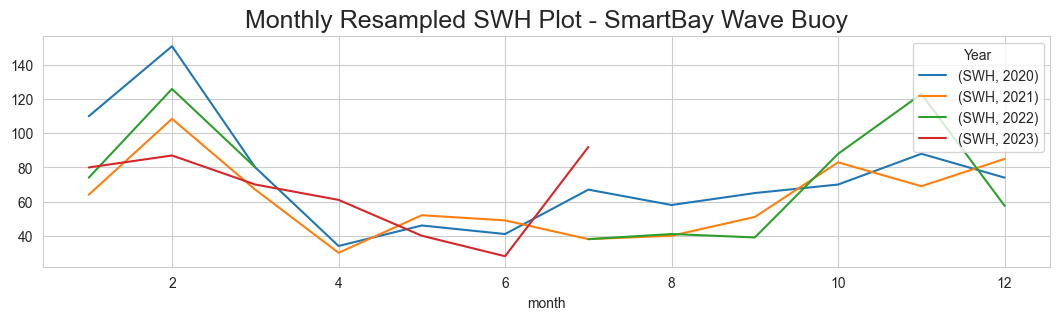

In [ ]:
monthly_smoothing_per_year_plot(df, 'AMETS Berth B Wave Buoy')    
monthly_smoothing_per_year_plot(df, 'AMETS Berth A Wave Buoy')  
monthly_smoothing_per_year_plot(df, 'SmartBay Wave Buoy') 

In [ ]:
def weekly_smoothing_per_year_plot(df, station, show_piv=False):
    
    df = df.loc[df['station_id']==station].copy()
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['year_month'] = df[['year','month']].apply(lambda x: '-'.join(x.values.astype(str)), axis='columns')
    df['year_month'] = pd.to_datetime(df['year_month'])
    df['week'] = df.index.isocalendar().week
    df = df[df['station_id']==station]
    df= df[['SWH','year','week','year_month']]
    
    piv = pd.pivot_table(df[df.index.year.isin([2021, 2022])], index=['week'],columns=['year'], values=['SWH'], aggfunc='median')
    fig, ax = plt.subplots(figsize=(13,3))
    
    piv.plot(ax=ax)
    ax.legend(title ='Year',fontsize=10)
    ax.set_title(f'Weekly Resampled SWH Plot - {station}', fontsize=18)
    
    plt.show()
    
    if show_piv==True:
        display('Plot Data:', piv)
 

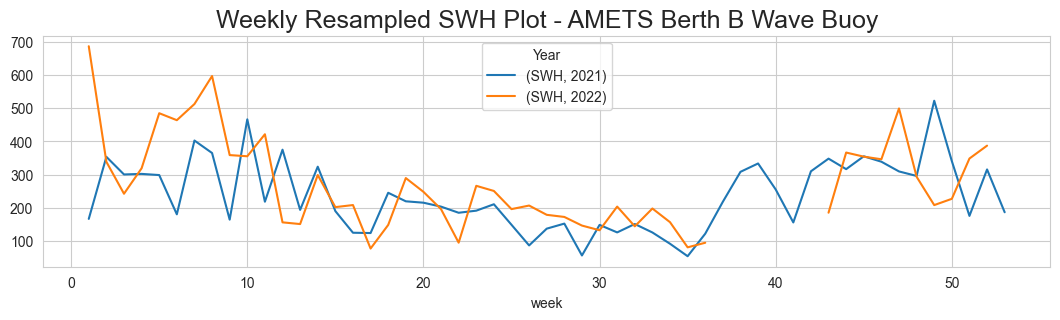

In [ ]:
weekly_smoothing_per_year_plot(df, 'AMETS Berth B Wave Buoy')

* There's a repeating pattern in the data that occurs on a yearly basis. This could be due to seasonal changes that influence the data each year. 
* There's no consistent and repeating pattern on a weekly or monthly basis.

# Correlation

Plot heatmap to visualize the correlation between features.

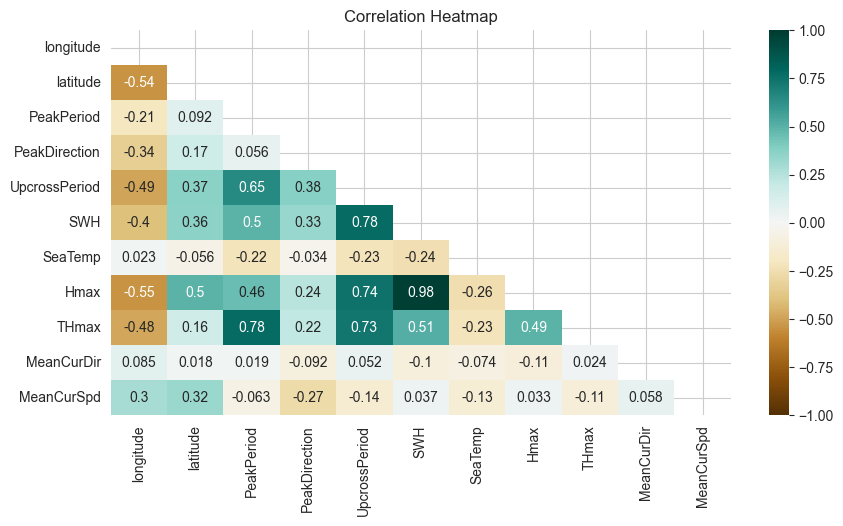

In [ ]:
# exclude the categorical values from the heatmap
base = df.drop(columns=['station_id', 'instrument'], axis=1)

plt.figure(figsize=(10,5))
mask = np.triu(np.ones_like(base.corr(), dtype=bool))
heatmap = sns.heatmap(base.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap')
plt.show()

* The most correlated feature to the target variable SWH is <b>Hmax</b> with 0.98 value. 
* The next correlated feature is <b>UpcrossPeriod</b> with 0.78. 
* <b>Hmax</b> and <b>UpcrossPeriod</b> are highly correlated to each other with 0.74 value.